# Predicting the weekly return of a stock

## Import all necessary libraries

In [1]:
# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Function and modules for the supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Function and modules for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Function and modules for deep learning models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Function and modules for time series models
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

## Loading the data

In [3]:
# Stock tickers
stock_tickers = ['MSFT', 'IBM', 'GOOGL']

# Currency tickers from FRED (USD/JPY and GBP/USD)
ccy_tickers = ['DEXJPUS', 'DEXUSUK']

# Indices tickers from FRED (S&P500, Dow Jones Industrial Avg and VIX)
indices_tickers = ['SP500', 'DJIA', 'VIXCLS']

stock_data = web.DataReader(stock_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
indices_data = web.DataReader(indices_tickers, 'fred')

In [4]:
stock_data.head()

Attributes  Adj Close                             Close              \
Symbols          MSFT         IBM      GOOGL       MSFT         IBM   
Date                                                                  
2017-08-08  68.179031  108.457726  47.209499  72.790001  135.860428   
2017-08-09  67.879303  108.198250  47.004002  72.470001  135.535370   
2017-08-10  66.886467  108.251709  46.179501  71.410004  135.602295   
2017-08-11  67.907402  108.251709  46.504501  72.500000  135.602295   
2017-08-14  68.928352  108.618019  46.946499  73.589996  136.061188   

Attributes                  High                               Low  \
Symbols         GOOGL       MSFT         IBM      GOOGL       MSFT   
Date                                                                 
2017-08-08  47.209499  73.129997  136.481842  47.624500  71.750000   
2017-08-09  47.004002  72.510002  135.783936  47.188000  72.050003   
2017-08-10  46.179501  72.190002  136.156784  46.814999  71.349998   
2017-08-11  46.504501  72.699997  136.319305  46.667999  71.279999   
2017-08-14  46.946499  73.720001  136.481842  47.051998  72.949997   

Attributes                              Open                         \
Symbols            IBM      GOOGL       MSFT         IBM      GOOGL   
Date                                                                  
2017-08-08  135.755264  47.124001  72.089996  135.755264  47.214500   
2017-08-09  134.980881  46.695999  72.250000  135.516251  46.922501   
2017-08-10  135.019119  46.089001  71.900002  135.411087  46.750000   
2017-08-11  135.296371  46.061001  71.610001  136.185471  46.185501   
2017-08-14  135.697891  46.724499  73.059998  135.755264  46.953499   

Attributes      Volume                         
Symbols           MSFT        IBM       GOOGL  
Date                                           
2017-08-08  22044600.0  3450440.0  30102000.0  
2017-08-09  22213400.0  3060387.0  28018000.0  
2017-08-10  24734500.0  4733568.0  54148000.0  
2017-08-11  21443700.0  3142184.0  32334000.0  
2017-08-14  20096600.0  2352036.0  23012000.0

In [5]:
ccy_data.head()

,DEXJPUS,DEXUSUK
DATE,,
2017-08-09,110.04,1.2997
2017-08-10,109.37,1.2978
2017-08-11,109.06,1.2988
2017-08-14,109.48,1.2975
2017-08-15,110.42,1.2862


In [6]:
indices_data.head()

,SP500,DJIA,VIXCLS
DATE,,,
2017-08-09,2474.02,22048.70,11.11
2017-08-10,2438.21,21844.01,16.04
2017-08-11,2441.32,21858.32,15.51
2017-08-14,2465.84,21993.71,12.33
2017-08-15,2464.61,21998.99,12.04


In [7]:
print(stock_data.shape)
print(ccy_data.shape)
print(indices_data.shape)

(1258, 18)
(1298, 2)
(1303, 3)


We get about 5 years worth of individual stock price, currency and indices prices data to work with.

## Define x and y variables
- y variable is the weekly return of the stock (in this case Microsoft)
- Number of trading days assumed to be five
- Independent or x variables:
    - Use correlated assets (currencies and indices) and historical returns of stock
    - Lagged five days return of stocks, currencies and indices
    - Lagged 5-day, 15-day, 30-day and 60-day of stock

In [8]:
# Define number of trading days
return_period = 5

# Set the y variable
# We will take the log of the Adjusted Close, then find the discrete difference over a 5-day period
# We then shift this 5-day difference back by 5 trading days
y = np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

# Rename the variable with "stock_ticker" & "pred" from the MultiIndex of Attribute & Symbols
y.name = y.name[-1] + '_pred'

In [9]:
y.head()

Date
2017-08-08    0.011204
2017-08-09    0.021465
2017-08-10    0.019082
2017-08-11    0.005176
2017-08-14   -0.014448
Name: MSFT_pred, dtype: float64

In [10]:
# Log stock prices, then find the 5-day return
# Drop level to change from Multi Index to single index
x1 = np.log(stock_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
x1.columns = x1.columns.droplevel()

# Log currency rates, then find the 5-day return
x2 = np.log(ccy_data).diff(return_period)

# Log indices level, then find the 5-day return
x3 = np.log(indices_data).diff(return_period)

# Find the 5-day, 15-day, 30-day and 60-day returns of MSFT stock
# Concat on the columns, then drop all the null rows
x4 = pd.concat([np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).\
                diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]],\
               axis=1).dropna()

# Rename the columns according to the return period
x4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [11]:
# Concat all the previous dataframes into one along columns axis
X = pd.concat([x1, x2, x3, x4], axis=1)

# Join y and x together into a single dataframe, drop null rows
# Slice df in intervals of 5 to get the weekly returns
df = pd.concat([y, X], axis=1).dropna().iloc[::return_period, :]

In [12]:
# Final dataset of weekly stock returns
df.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-11-01,0.016454,0.050294,0.003446,0.002986,0.000377,0.008648,0.004514,-0.096201,0.056254,0.084763,0.104319,0.138742
2017-11-08,-0.013852,0.014937,-0.016100,-0.003690,-0.011303,0.005806,0.005462,-0.042048,0.016454,0.085765,0.135425,0.143993
2017-11-16,0.000721,0.000716,-0.007882,-0.004507,0.004861,0.000395,-0.000153,0.113329,-0.005631,0.059852,0.095918,0.139640
2017-11-27,-0.033832,0.034274,0.020004,-0.013334,0.006924,0.007439,0.006401,-0.076060,0.017683,0.001796,0.084129,0.119861
2017-12-05,0.047745,-0.041958,0.018713,0.014561,0.016417,0.000963,0.014325,0.121873,-0.039532,-0.023267,0.039422,0.092433


In [22]:
# Separate into X and y variables
y = df.loc[:, y.name]
X = df.loc[:, X.columns]

## EDA: Exploratory Data Analysis

In [13]:
df.isnull().sum()

MSFT_pred    0
GOOGL        0
IBM          0
DEXJPUS      0
DEXUSUK      0
SP500        0
DJIA         0
VIXCLS       0
MSFT_DT      0
MSFT_3DT     0
MSFT_6DT     0
MSFT_12DT    0
dtype: int64

In [14]:
df.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.005838,0.003429,-0.000795,0.000772,-0.000698,0.001156,0.000427,0.005656,0.005461,0.016992,0.032889,0.067492
std,0.033268,0.039506,0.034790,0.010307,0.012969,0.026176,0.027004,0.172148,0.034823,0.056349,0.072937,0.094393
min,-0.107017,-0.131878,-0.130376,-0.040101,-0.091515,-0.133785,-0.168597,-0.485004,-0.107017,-0.198058,-0.246400,-0.189026
25%,-0.012339,-0.015319,-0.017040,-0.005123,-0.007430,-0.005899,-0.009234,-0.096201,-0.012875,-0.010608,-0.004088,0.011721
50%,0.008847,0.005160,0.003446,0.001090,-0.000373,0.003946,0.003857,-0.019048,0.008499,0.024454,0.043421,0.085576
75%,0.026264,0.023908,0.020004,0.006791,0.008222,0.013933,0.013558,0.084989,0.027178,0.051036,0.082369,0.134842
max,0.082129,0.144602,0.126265,0.034140,0.052253,0.107173,0.112341,0.706579,0.101180,0.186487,0.227306,0.345888


### Visualisation using a correlation heatmap

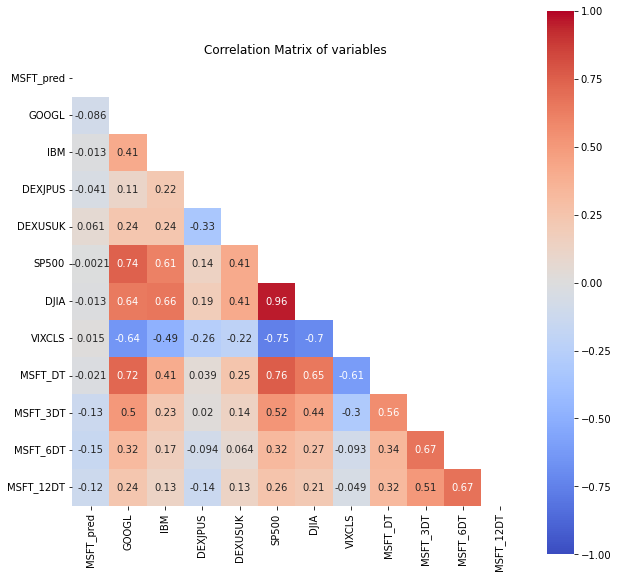

In [15]:
# Find the correlation between the variables
df_corr = df.corr()

# Masking the plot
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)]=True

# Plot the heatmap
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix of variables')
sns.heatmap(df_corr, vmax=1, vmin=-1, square=True, annot=True, cmap='coolwarm', mask=mask);

There seems to be some correlation of the predicted variable with the lagged 5 days, 15 days, 30 days and 60 days return of the stock.

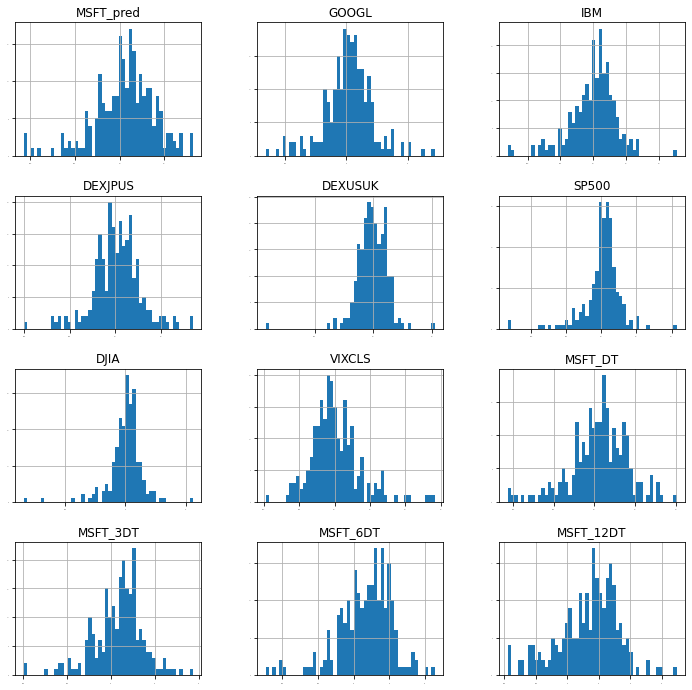

In [16]:
# distribution of each series individually
df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show();

<Figure size 1080x1080 with 0 Axes>

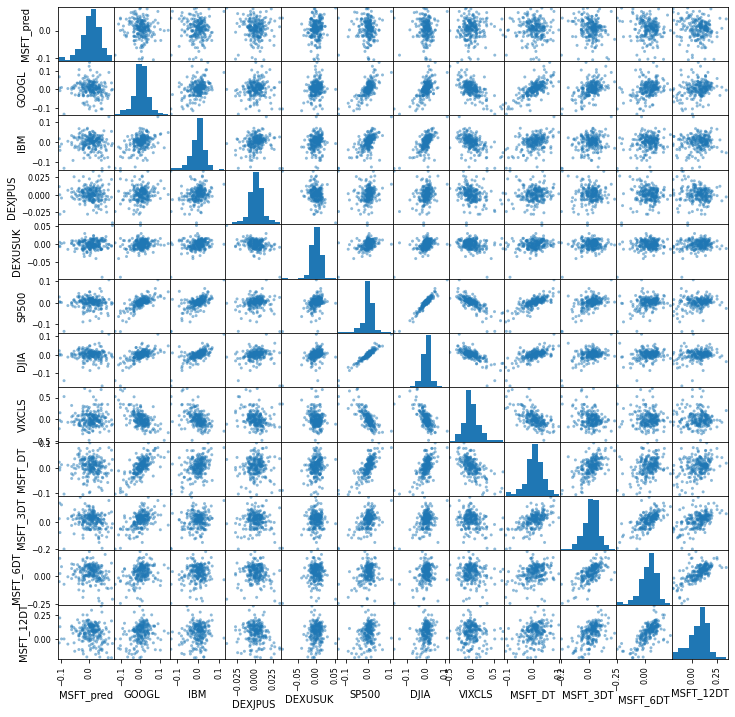

In [17]:
plt.figure(figsize=(15,15))
scatter_matrix(df,figsize=(12,12))
plt.show();

There seems to be some sort of linear relationship between the predicted variable and the lagged returns.

## Time series analysis

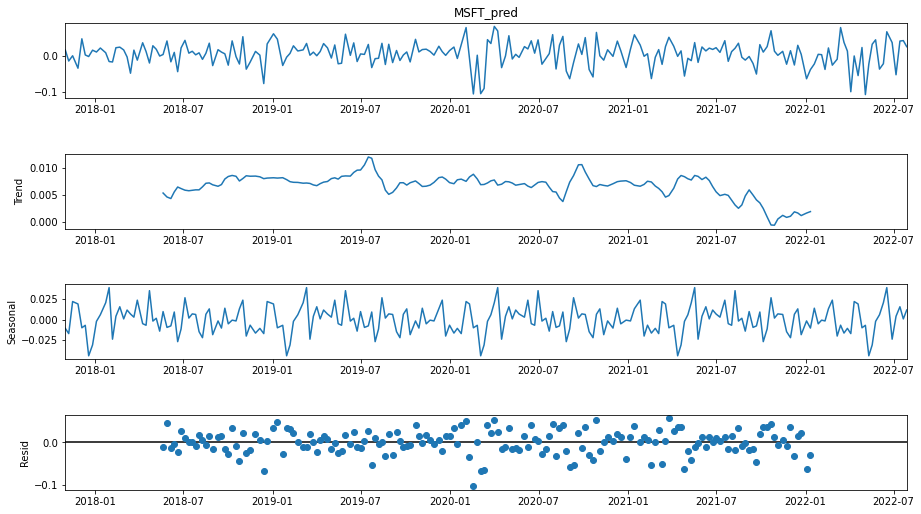

In [21]:
res = sm.tsa.seasonal_decompose(y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show();

We can see that for MSFT there has been a general trend downwards. This should show up in our constant/bias terms in our models.

## Feature Selection
- We use sklearn's SelectKBest function to get a sense of feature importance.

In [24]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_6DT,5.391669
MSFT_3DT,3.987597
MSFT_12DT,3.348118
GOOGL,1.673410
DEXUSUK,0.839969
DEXJPUS,0.375513
MSFT_DT,0.097166
VIXCLS,0.053057
IBM,0.039933


We see that the 30 days lagged return is the most important feature, while the DJIA is the least important.

## Train-test split

In [25]:
validation_size = 0.2

# In case the data is not dependent on the time series, then train and test split randomly
# seed = 42
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
# This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [26]:
num_folds = 10
seed = 42
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

## Models

In [27]:
# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [28]:
# Neural network algorithms
models.append(('MLP', MLPRegressor()))

In [29]:
# Ensemble models algorithms

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. 
1. First we run the K-fold analysis. 
2. Next we run the model on the entire training and testing dataset

In [32]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Converted mean square error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, y_train)
    train_result = mean_squared_error(res.predict(X_train), y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001127 (0.000426) 0.000887 0.001828
LASSO: 0.000993 (0.000358) 0.000966 0.001660
EN: 0.000993 (0.000358) 0.000966 0.001660
KNN: 0.001209 (0.000464) 0.000758 0.001731
CART: 0.002351 (0.001078) 0.000000 0.003310
SVR: 0.001335 (0.000338) 0.001327 0.001714
MLP: 0.002690 (0.001841) 0.001847 0.002480
ABR: 0.001119 (0.000356) 0.000480 0.001812
GBR: 0.001350 (0.000521) 0.000070 0.002052
RFR: 0.001210 (0.000373) 0.000166 0.001977
ETR: 0.001246 (0.000471) 0.000000 0.001849


### K-fold results

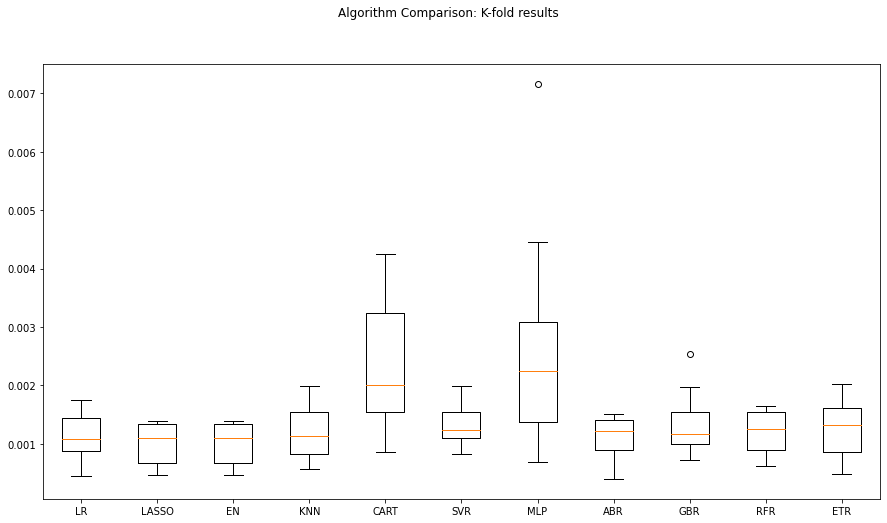

In [33]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: K-fold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show();